# Double integrator

For this example we demonstrate learning control for a double integrator system. In this case we learn the control from directly interacting with the system in a typical RL scenario. 

In [3]:
# !pip install setuptools==61.0.0 pyts mlflow plum-dispatch==1.7.2 torchdiffeq
# !pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps
# Uncomment pip installs for Colab notebook    
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [5]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# closed loop system definition
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

xnext = lambda x, u: x @ A.T + u @ B.T
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')
cl_system = System([policy, double_integrator])
# cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [6]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [7]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.001 * (u == 0.)^2  # control penalty
regulation_loss = 5. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [8]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer,
    epochs=500,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuromancer\src\neuromancer\constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuromancer\src\neuromancer\constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 3, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 98.00830841064453
epoch: 1  train_loss: 97.67691802978516
epoch: 2  train_loss: 97.36073303222656
epoch: 3  train_loss: 97.05933380126953
epoch: 4  train_loss: 96.77058410644531
epoch: 5  train_loss: 96.49188995361328
epoch: 6  train_loss: 96.21820068359375
epoch: 7  train_loss: 95.9455795288086
epoch: 8  train_loss: 95.66926574707031
epoch: 9  train_loss: 95.38706970214844
epoch: 10  train_loss: 95.0980453491211
epoch: 11  train_loss: 94.80287170410156
epoch: 12  train_loss: 94.50047302246094
epoch: 13  train_loss: 94.18836212158203
epoch: 14  train_loss: 93.86542510986328
epoch: 15  train_loss: 93.5295181274414
epoch: 16  train_loss: 93.17898559570312
epoch: 17  train_loss: 92.81240844726562
epoch: 18  train_loss: 92.42830657958984
epoch: 19  train_loss: 92.02645874023438
epoch: 20  train_loss: 91.60570526123047
epoch: 21  train_loss: 91.16617584228516
epoch: 22  train_loss: 90.70719146728516
epoch: 23  train_loss: 90.22814178466797
epoch: 24  train_loss: 89.728

epoch: 199  train_loss: 19.21961784362793
epoch: 200  train_loss: 19.21895408630371
epoch: 201  train_loss: 19.218297958374023
epoch: 202  train_loss: 19.2176570892334
epoch: 203  train_loss: 19.217021942138672
epoch: 204  train_loss: 19.216402053833008
epoch: 205  train_loss: 19.215789794921875
epoch: 206  train_loss: 19.215190887451172
epoch: 207  train_loss: 19.2145938873291
epoch: 208  train_loss: 19.21401023864746
epoch: 209  train_loss: 19.21343994140625
epoch: 210  train_loss: 19.21288299560547
epoch: 211  train_loss: 19.212329864501953
epoch: 212  train_loss: 19.2117862701416
epoch: 213  train_loss: 19.211254119873047
epoch: 214  train_loss: 19.210725784301758
epoch: 215  train_loss: 19.21021842956543
epoch: 216  train_loss: 19.209712982177734
epoch: 217  train_loss: 19.20922088623047
epoch: 218  train_loss: 19.20873260498047
epoch: 219  train_loss: 19.208255767822266
epoch: 220  train_loss: 19.20778465270996
epoch: 221  train_loss: 19.20732307434082
epoch: 222  train_loss: 19.

epoch: 392  train_loss: 19.1745662689209
epoch: 393  train_loss: 19.174480438232422
epoch: 394  train_loss: 19.174396514892578
epoch: 395  train_loss: 19.174312591552734
epoch: 396  train_loss: 19.17422866821289
epoch: 397  train_loss: 19.174148559570312
epoch: 398  train_loss: 19.1740665435791
epoch: 399  train_loss: 19.173988342285156
epoch: 400  train_loss: 19.17390251159668
epoch: 401  train_loss: 19.173826217651367
epoch: 402  train_loss: 19.173748016357422
epoch: 403  train_loss: 19.173667907714844
epoch: 404  train_loss: 19.173587799072266
epoch: 405  train_loss: 19.17350959777832
epoch: 406  train_loss: 19.173433303833008
epoch: 407  train_loss: 19.173355102539062
epoch: 408  train_loss: 19.173276901245117
epoch: 409  train_loss: 19.173202514648438
epoch: 410  train_loss: 19.173128128051758
epoch: 411  train_loss: 19.173051834106445
epoch: 412  train_loss: 19.172975540161133
epoch: 413  train_loss: 19.17290496826172
epoch: 414  train_loss: 19.172828674316406
epoch: 415  train_l

# Evaluate best model on a system rollout of 50 time steps


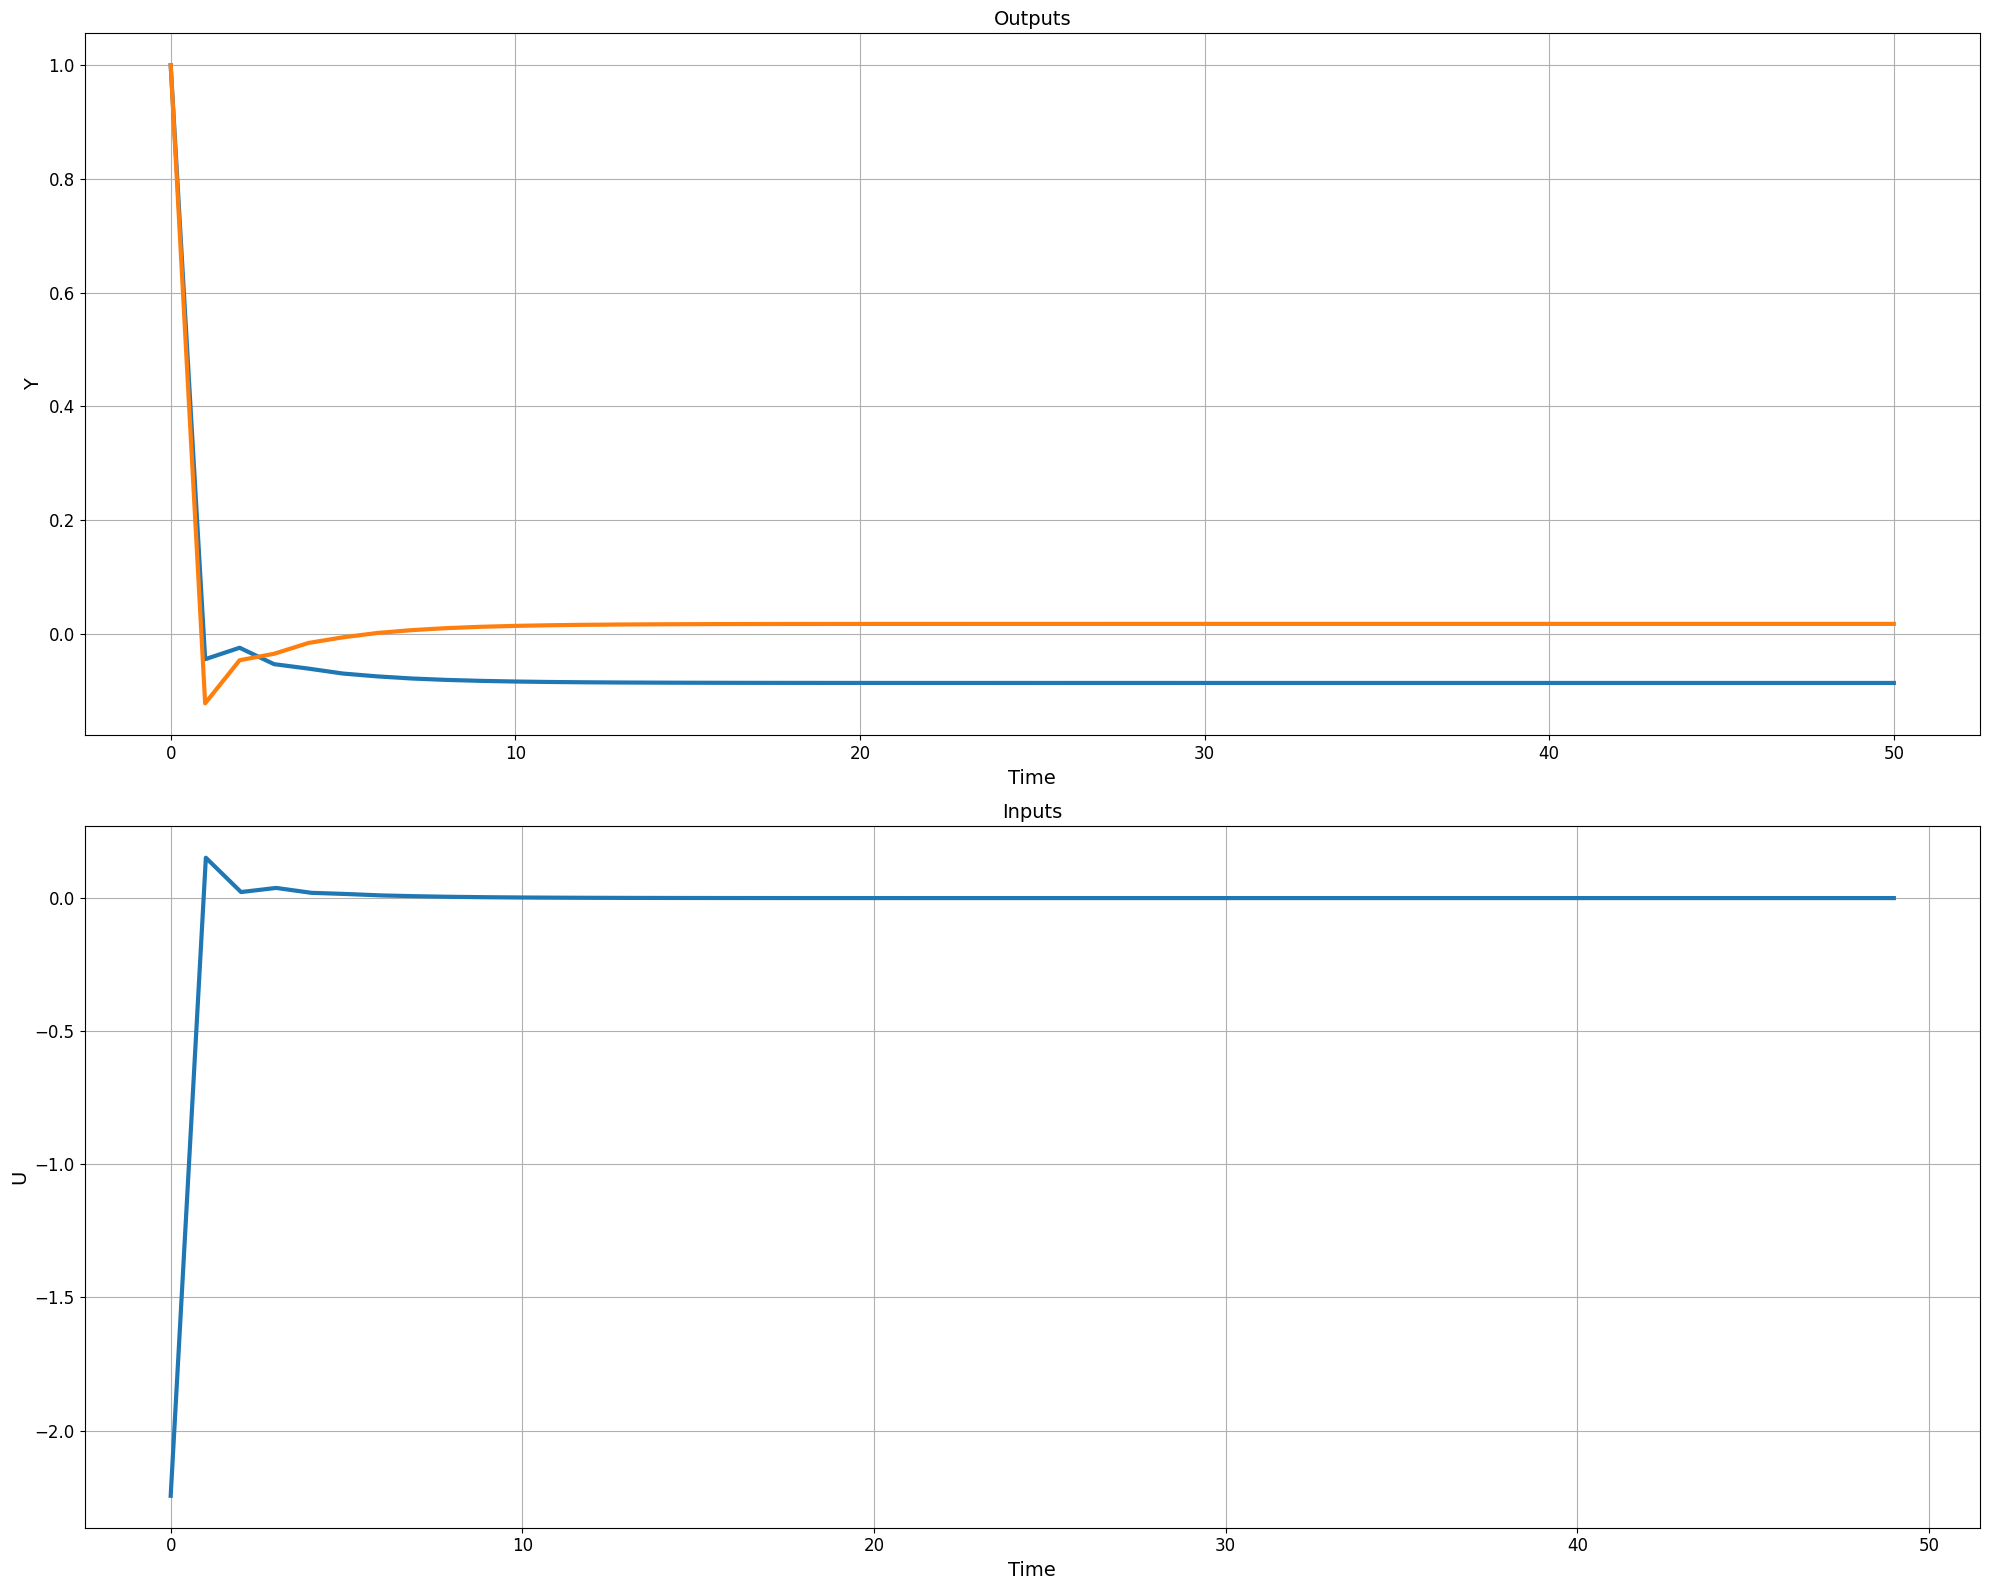

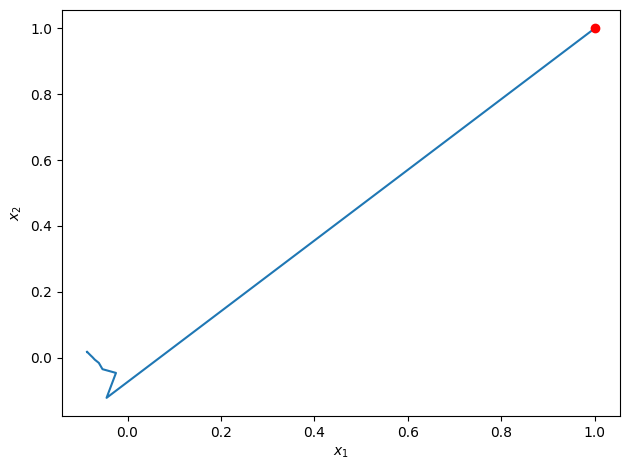

<Figure size 640x480 with 0 Axes>

In [9]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
cl_system.nsteps = 50
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(51, 2), U=trajectories['U'].detach().reshape(50, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(51, 2), figname='phase.png')